In [6]:
import os
import zipfile
from io import TextIOWrapper
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
# import leafmap
import xarray as xr

In [7]:
# Set a workdir and go to it
workdir = '/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis'
print('Going to work dir: ', workdir)
os.chdir(workdir)

Going to work dir:  /Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_analysis


#### First read the RTC information

In [8]:
# Read slc for processing
df_rtc = pd.read_json('/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/marshak/4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


#### Choose a burst of interest and get all related acquisitions 

In [9]:
# Get all acquisitions for a burst
BURST_ID = 'T005-008692-IW2'
df_burst_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)
print('Total dates for burst', BURST_ID, '=', len(df_burst_ts))
df_burst_ts.head()

Total dates for burst T005-008692-IW2 = 104


,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008692-IW2_20201004T00392...,S1B_IW_SLC__1SDV_20201004T003926_20201004T0039...,T005-008692-IW2,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-04 00:39:26
1,OPERA_L2_RTC-S1_T005-008692-IW2_20201010T00401...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008692-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
2,OPERA_L2_RTC-S1_T005-008692-IW2_20201016T00393...,S1B_IW_SLC__1SDV_20201016T003926_20201016T0039...,T005-008692-IW2,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-16 00:39:26
3,OPERA_L2_RTC-S1_T005-008692-IW2_20201022T00401...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008692-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
4,OPERA_L2_RTC-S1_T005-008692-IW2_20201028T00393...,S1B_IW_SLC__1SDV_20201028T003926_20201028T0039...,T005-008692-IW2,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-28 00:39:26


#### Build RTC burst time series with xarray

In [10]:
polarizations = ['vv', 'vh']
da_stack = []

for t, row in df_burst_ts.iterrows():
    rtc_id = row['rtc_s1_id']
    time = pd.to_datetime(row['acq_datetime'])
    polarization_stack = []

    for polarization in polarizations:
        file_path = row[f"rtc_s1_{polarization}_url"]
     
        # with fs.open(file_path, mode='rb') as f:
        da = xr.open_dataarray(file_path, engine="rasterio")
        da = da.expand_dims(time=pd.Index([time], name='time'))
        polarization_stack.append(da)

    da_polarized = xr.concat(polarization_stack, dim=pd.Index(polarizations, name='polarization'))
    da_stack. append(da_polarized)

ds = xr.concat(da_stack, dim='time')
ds


<xarray.DataArray 'band_data' (polarization: 2, time: 104, band: 1, y: 1619,
                               x: 3435)> Size: 5GB
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
...
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]],


        [[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 832B 2020-10-04T00:39:26 ... 2022-11-...
  * band          (band) int64 8B 1
  * x             (x) float64 27kB 5.932e+05 5.932e+05 ... 6.962e+05 6.962e+05
  * y             (y) float64 13kB 1.982e+06 1.982e+06 ... 1.933e+06 1.933e+06
    spatial_ref   int64 8B 0
  * polarization  (polarization) object 16B 'vv' 'vh'
Attributes: (12/84)
    ABSOLUTE_ORBIT_NUMBER:                                                   ...
    ACQUISITION_MODE:                                                        ...
    AREA_OR_POINT:                                                           ...
    BOUNDING_BOX:                                                            ...
    BOUNDING_BOX_EPSG_CODE:                                                  ...
    BOUNDING_BOX_PIXEL_COORDINATE_CONVENTION:                                ...
    ...                                                                         ...
    STATIC_LAYERS_DATA_ACCESS:                                               ...
    SUB_SWATH_ID:                                                            ...
    TRACK_NUMBER:                                                            ...
    ZERO_DOPPLER_END_TIME:                                                   ...
    ZERO_DOPPLER_START_TIME:                                                 ...
    long_name:                                                               ...

Center Coordinates:
x: 644715.0, y: 1957725.0


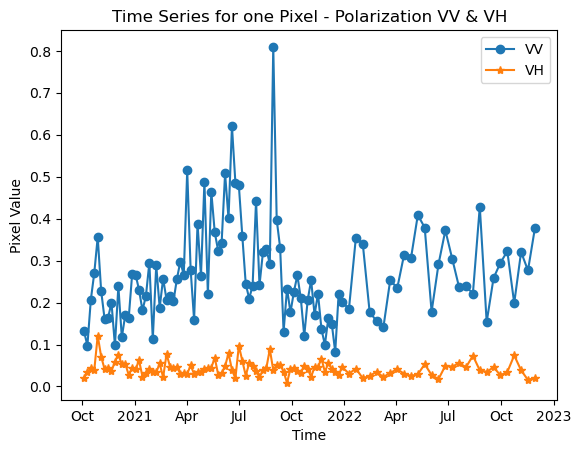

In [52]:
# Calculate the center coordinates
center_x = ds.x.mean().values
center_y = ds.y.mean().values

print("Center Coordinates:")
print(f"x: {center_x}, y: {center_y}")

sample_ts_vv = ds.sel(x=center_x, y=center_y, polarization='vv')
sample_ts_vh = ds.sel(x=center_x, y=center_y, polarization='vh') 
# Plotting the time series
sample_ts_vv.plot(marker='o', linestyle='-', label='VV')
sample_ts_vh.plot(marker='*', linestyle='-', label='VH')
plt.title('Time Series for one Pixel - Polarization VV & VH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pixel Value')
plt.show()

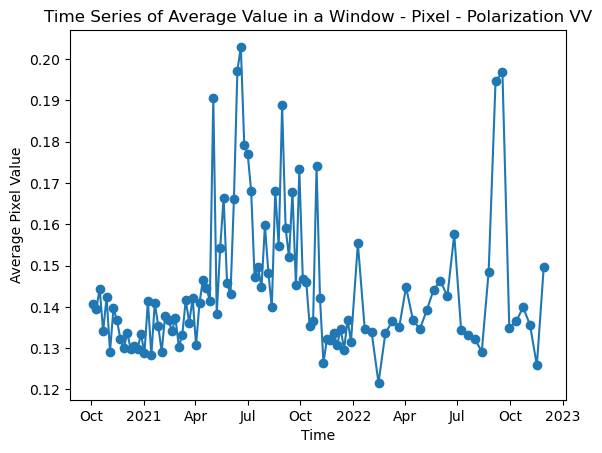

In [12]:
# Define the size of the window
window_size = 50

# # Select a subset of the data around the center pixel for a specific polarization
# subset_data = ds.sel(x=slice(center_x - window_size//2, center_x + window_size//2),
#                      y=slice(center_y - window_size//2, center_y + window_size//2),
#                      polarization='vv')  # Change polarization as needed

subset_data = ds.sel(polarization='vv', x=slice(644715.0, 645715.0), y=slice(1957725.0, 1937725.0))

# Compute the average within the subset window
average_within_window = subset_data.mean(dim=('x', 'y'), skipna=True)

# Plot the time series
average_within_window.plot(marker='o', linestyle='-')
plt.title(f'Time Series of Average Value in a Window - Pixel - Polarization VV')
plt.xlabel('Time')
plt.ylabel('Average Pixel Value')
plt.show()

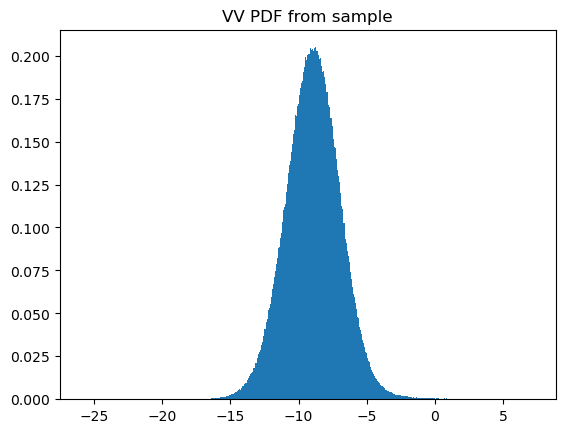

In [13]:
# Get the PDF from the subset
time_series_data = subset_data.values.flatten()  # Assuming 'ds' contains the time series data

# Remove NaN values from the time series data
time_series_data = time_series_data[~np.isnan(time_series_data)]
time_series_data = 10 * np.log10(time_series_data)

# Compute the histogram of the time series data
hist, bin_edges = np.histogram(time_series_data, bins='auto', density=False)

# Compute the width of each bin
bin_width = bin_edges[1] - bin_edges[0]

# Compute the probability density function (PDF)
pdf = hist / (np.sum(hist) * bin_width)

# Plot the PDF
plt.bar(bin_edges[:-1], pdf, width=bin_width)
plt.title('VV PDF from sample')
plt.show()

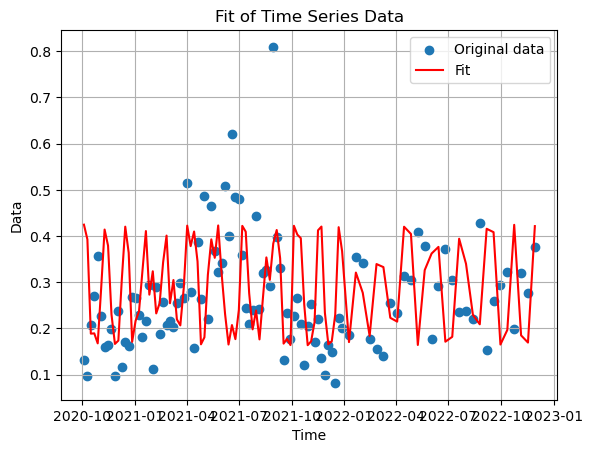

In [49]:
# Polyfit
from scipy.optimize import curve_fit

time_series = sample_ts_vv['time'].values
points = sample_ts_vv.values.squeeze()

# # Define the polynomial function
# def polynomial_func(x, a, b, c):
#     return a * x**3 + b * x + c  # Change the degree of the polynomial as needed

# Define the sine function
def sine_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Initial guesses for the parameters
initial_guesses = (0.3, 1, 0, 5)  # (a, b, c, d)

# Bounds for the parameters (optional)
bounds = ([0, 0, -np.pi, -np.inf], [np.inf, np.inf, np.pi, np.inf])  # (lower bounds, upper bounds)

# Fit the function to the data
# popt, _ = curve_fit(sine_func, time_series, points)

# Fit the sine function to the data
popt, pcov = curve_fit(sine_func, time_series, points, p0=initial_guesses, bounds=bounds)

# Get the coefficients of the fitted polynomial
# # a, b, c = popt

# Extract optimized parameters
# a_opt, b_opt, c_opt, d_opt = popt

# # Print the coefficients
# print("Coefficients:", a, b, c)

# plot
# Plot the original data
plt.scatter(time_series, points, label='Original data')

# Plot the fitted polynomial curve
plt.plot(time_series, sine_func(time_series.astype(float), *popt), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Fit of Time Series Data')
plt.legend()
plt.grid(True)
plt.show()